# Add New Explanation Backend

---

This notebook is part of https://github.com/risc-mi/catabra.

This notebook demonstrates how a new explanation backend can be added to CaTabRa, i.e.,
* [how it can be implemented](#Implement-Random-Explainer), and
* [how it can be utilized in CaTabRa's data analysis workflow](#Utilize-Random-Explainer).

## Implement Random Explainer

We implement a new dummy explanation backend that returns random feature importance scores. If you intend to actually add a new explanation backend, don't forget to have a look at the implementation of the default SHAP explanation backend in [catabra/explanation/_shap/backend.py](https://github.com/risc-mi/catabra/tree/main/catabra/explanation/_shap/backend.py).

In [3]:
from typing import Optional
import numpy as np
import pandas as pd

from catabra.explanation.base import TransformationExplainer, IdentityTransformationExplainer, EnsembleExplainer
from catabra.automl.base import FittedEnsemble

Explanation backends need to implement the abstract base class `catabra.explanation.base.EnsembleExplainer`. The main methods of interest are `explain()` and `explain_global()` for producing local (sample-wise) and global explanations, respectively.

In [4]:
class RandomEnsembleExplainer(EnsembleExplainer):
    
    @property
    def name(self) -> str:
        return 'random_explainer'
    
    @property
    def behavior(self) -> dict:
        return dict(
            supports_local=True,
            requires_y=False,
            global_accepts_x=True,
            global_requires_x=True,
            global_is_mean_of_local=True
        )
    
    def __init__(self, ensemble: FittedEnsemble = None, config: Optional[dict] = None,
             feature_names: Optional[list] = None, target_names: Optional[list] = None,
             x: Optional[pd.DataFrame] = None, y: Optional[pd.DataFrame] = None, params=None):
        super(RandomEnsembleExplainer, self).__init__(ensemble=ensemble, config=config, feature_names=feature_names,
                                                      target_names=target_names, x=x, y=y, params=params)
        
        # `ensemble` is the ensemble of one or more models we will explain,
        #    in the uniform `FittedEnsemble` representation.
        # Note: If the explainer needs to know the prediction task `ensemble` was trained for
        #    (binary/multiclass/multilabel classification, regression),
        #    it can be accessed via `ensemble.task`.
        self._ensemble = ensemble
        
        if params is None:
            assert x is not None
            if feature_names is None:
                self._feature_names = list(range(x.shape[1]))
            else:
                assert len(feature_names) == x.shape[1]
                self._feature_names = feature_names
            self._params = dict(feature_names=self._feature_names)
        else:
            self._params = params
            self._feature_names = self._params['feature_names']
    
    @property
    def params_(self) -> dict:
        return self._params
    
    def explain(self, x: pd.DataFrame, jobs: int = 1, batch_size: Optional[int] = None, model_id=None,
                show_progress: bool = False) -> dict:
        if model_id is None:
            keys = ['__ensemble__']
        elif not isinstance(model_id, (list, set)):
            keys = [model_id]
        else:
            keys = model_id
        
        # explain models with IDs in `keys` on data `x`,
        # and return DataFrames with one row per sample and one column per feature
        
        return {
            k: pd.DataFrame(
                index=x.index,
                columns=self._feature_names,
                data=np.random.uniform(-1, 1, size=(len(x), len(self._feature_names)))
            )
            for k in keys
        }
    
    def explain_global(self, x: Optional[pd.DataFrame] = None, sample_weight: Optional[np.ndarray] = None,
                       jobs: int = 1, batch_size: Optional[int] = None, model_id=None,
                       show_progress: bool = False) -> dict:
        local_explanation = self.explain(x, jobs=jobs, batch_size=batch_size)
        return {k: e.mean(axis=0) for k, e in local_explanation.items()}
    
    def get_versions(self) -> dict:
        return {}

Finally, the new backend needs to be registered:

In [5]:
EnsembleExplainer.register('random_explainer', RandomEnsembleExplainer)

## Utilize Random Explainer

We now utilize the new `"random_explainer"` in a simple classification problem. Everthing shown works analogously for all other prediction tasks.

In [6]:
# load dataset
from sklearn.datasets import load_breast_cancer
X, y = load_breast_cancer(as_frame=True, return_X_y=True)

In [7]:
# add target labels to DataFrame
X['diagnosis'] = y

In [8]:
# split into train- and test set by adding column with corresponding values
# the name of the column is arbitrary; CaTabRa tries to "guess" which samples belong to which set based on the column name and -values
X['train'] = X.index <= 0.8 * len(X)

When analyzing the data, we inform CaTabRa that we want to use the `"random_explainer"` backend by adjusting the config dict:

In [16]:
from catabra.analysis import analyze

analyze(
    X,
    classify='diagnosis',     # name of column containing classification target
    split='train',            # name of column containing information about the train-test split (optional)
    time=1,                   # time budget for hyperparameter tuning, in minutes (optional)
    out='random_explainer_example',
    config={
        'explainer': 'random_explainer'     # name of the explanation backend
    }
)

[CaTabRa] ### Analysis started at 2023-02-08 13:37:52.815507
[CaTabRa] Saving descriptive statistics completed
[CaTabRa] Using AutoML-backend auto-sklearn for binary_classification
[CaTabRa] Successfully loaded the following auto-sklearn add-on module(s): xgb


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


[CaTabRa] New ensemble fitted:
    ensemble_val_roc_auc: 0.980337
    n_constituent_models: 1
    total_elapsed_time: 00:02
[CaTabRa] New model #1 trained:
    val_roc_auc: 0.980337
    val_accuracy: 0.927152
    val_balanced_accuracy: 0.928416
    train_roc_auc: 1.000000
    type: random_forest
    total_elapsed_time: 00:02
[CaTabRa] New ensemble fitted:
    ensemble_val_roc_auc: 0.994744
    n_constituent_models: 1
    total_elapsed_time: 00:03
[CaTabRa] New model #2 trained:
    val_roc_auc: 0.994744
    val_accuracy: 0.947020
    val_balanced_accuracy: 0.947717
    train_roc_auc: 0.996970
    type: passive_aggressive
    total_elapsed_time: 00:03
[CaTabRa] New ensemble fitted:
    ensemble_val_roc_auc: 0.994744
    n_constituent_models: 1
    total_elapsed_time: 00:04
[CaTabRa] New model #3 trained:
    val_roc_auc: 0.970098
    val_accuracy: 0.920530
    val_balanced_accuracy: 0.915458
    train_roc_auc: 1.000000
    type: gradient_boosting
    total_elapsed_time: 00:04
[CaTabRa] 

[CaTabRa] Final training statistics:
    n_models_trained: 27
    ensemble_val_roc_auc: 0.9980065241029358
[CaTabRa] Creating random_explainer explainer
[CaTabRa] Initialized out-of-distribution detector of type Autoencoder
[CaTabRa] Fitting out-of-distribution detector...
Iteration 1, loss = 0.03357227
Iteration 2, loss = 0.01514664
Iteration 3, loss = 0.01278397
Iteration 4, loss = 0.01196129
Iteration 5, loss = 0.01211510
Iteration 6, loss = 0.01164266
Iteration 7, loss = 0.01154587
Iteration 8, loss = 0.01141252
Iteration 9, loss = 0.01136364
Iteration 10, loss = 0.01132645
Iteration 11, loss = 0.01130890
Iteration 12, loss = 0.01127884
Iteration 13, loss = 0.01127261
Iteration 14, loss = 0.01125695
Iteration 15, loss = 0.01123986
Iteration 16, loss = 0.01123657
Iteration 17, loss = 0.01122498
Iteration 18, loss = 0.01124556
Iteration 19, loss = 0.01124696
Iteration 20, loss = 0.01129455
Iteration 21, loss = 0.01124538
Iteration 22, loss = 0.01125602
Iteration 23, loss = 0.01124848

The rest proceeds as usual:

In [17]:
from catabra.explanation import explain

explain(
    X,
    folder='random_explainer_example',
    from_invocation='random_explainer_example/invocation.json',
    out='random_explainer_example/explain'
)

[CaTabRa] ### Explanation started at 2023-02-08 13:39:13.711701
[CaTabRa] *** Split train
[CaTabRa] *** Split not_train
[CaTabRa] ### Explanation finished at 2023-02-08 13:39:16.310196
[CaTabRa] ### Elapsed time: 0 days 00:00:02.598495
[CaTabRa] ### Output saved in /mnt/c/Users/amaletzk/Documents/CaTabRa/catabra/examples/random_explainer_example/explain


In [18]:
from catabra.util.io import read_df
ex = read_df('random_explainer_example/explain/not_train/__ensemble__.h5')

As can be seen, the feature importance scores are completely random:

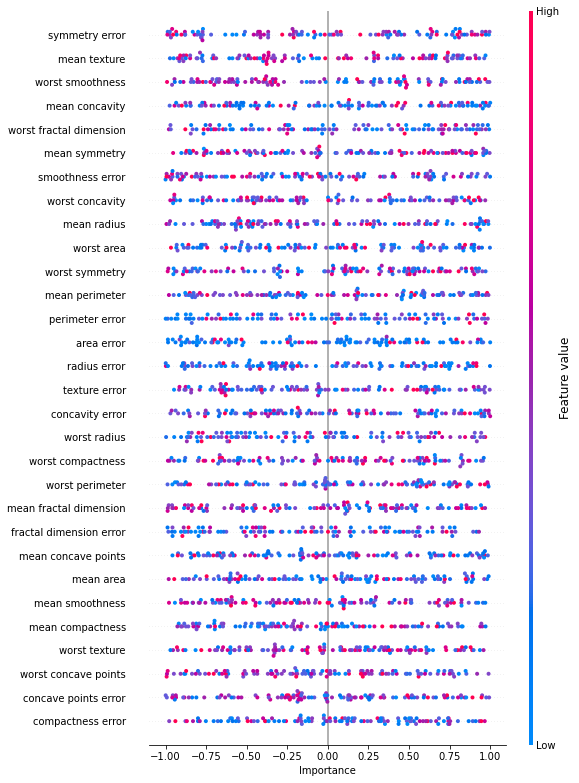

In [19]:
from catabra.explanation import plot_beeswarms
plot_beeswarms(ex, features=X[~X['train']])